In [126]:
from baselines.common import plot_util as pu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import csv

In [127]:
fps = []
plt.rcParams["figure.figsize"] = (30,30)

In [128]:
#TODO
#jumpstart in 500-rolling mean
# table of norm 500-score transfer - norm 500-score baseline

In [129]:
def find_t_at_r(reward_thres, roll_mean_df, log_df):
    thres = roll_mean_df.loc[roll_mean_df.r >= reward_thres]
    idx = thres.index[0]
    time_series = np.cumsum(log_df.l)
    return time_series[idx]

def plot_r_thres(r):
    plt.plot([0, 1e7], [r, r], color='k', linestyle='--', linewidth=2)

def plot_t_thres(t, min_y,max_y):
    plt.plot([t, t], [min_y, max_y], color='k', linestyle='--', linewidth=2)
    
def find_r_at_t(time_thres , roll_mean_df, log_df):
    time_series = np.cumsum(log_df.l)
    thres = time_series.loc[time_series >= time_thres]
    idx = thres.index[0]
    return roll_mean_df.r[idx]

In [130]:
def get_thres(key):
    game = re.search(r'\w{2,5}(?=_)',key).group()
    #Human level scores as declared in https://www.nature.com/articles/nature14236.pdf pg 11
    thresholds = {\
        'si' : [1652,0,1700],\
        'da' : [3401,0,8000],\
        'pong' : [9.3,-21,21], \
        'qb' : [13455,0,18000]          
    }
    thres=[0,0];
    try:
        thres = thresholds[game]
    except KeyError: 
        print("key doesn't contain game!")
    return thres 

In [131]:
def normalize_score(score,norm_up,norm_low):
    norm_score = (score-norm_low)/(norm_up-norm_low)
    return norm_score

def avg(a,b):
    val = (a+b)/2
    return val 

In [154]:
def plot_lc(games_algo_dict):
    i = 0
    n = 500 #rolling points 
    with open('data.csv','w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['fp1','fp2','t_to_thres','r_at_t,r_mean','s_mean','norm_rs'*5,'d_norm'*5])
        for key in games_algo_dict:
            plt.subplot(421+i)
            fps1 = games_algo_dict[key]
            fp0 = games_algo_dict2[key][0]
            results0 =  pu.load_results(fp0)
            r0 = results0[0]
            m0 = r0.monitor
            u0 = m0.rolling(n).mean()
            plt.plot(np.cumsum(r0.monitor.l), u0.r,label=fp0[5:])
            
            time_thres=0
            t_to_thres=0
            j=0
            baseline_norm = [0]*5            
            for j in range(0,len(fps1),2):
                fp1 = fps1[j]
                fp2 = fps1[j+1]
                results1 =  pu.load_results(fp1)
                
                results2 =  pu.load_results(fp2)
                r1 = results1[0]
                r2 = results2[0]
                m1 = r1.monitor
                m2 = r2.monitor
                
                u1 = m1.rolling(n).mean()
                u2 = m2.rolling(n).mean()
                s1 = m1.rolling(n).std()
                s2 = m2.rolling(n).std()
                s_mean = avg(s1.r[1:].mean(0), s2.r[1:].mean(0))
                r_mean = avg(m1.r[1:].mean(0), m2.r[1:].mean(0))
                
                thres_range = get_thres(key)
                reward_thres = thres_range[0]
                min_thres = thres_range[1]
                
                try:
                    t_to_thres = avg(find_t_at_r(reward_thres, u1, m1),find_t_at_r(reward_thres, u2, m2))
                except:
                    t_to_thres = 0
                
                r_at_t=0
                
                if t_to_thres!=0:
                    r_at_t = avg(find_r_at_t(t_to_thres , u1, m1),find_r_at_t(t_to_thres , u2, m2))
                #print(fp1,fp2)
                #print("t_to_thres:",t_to_thres,"\t","r_at_t:",r_at_t,"\t","s_mean:",s_mean)
                
                r_0 = avg(u1.r[n],u2.r[n])
                r_25 = avg(find_r_at_t(0.25e7, u1, m1),find_r_at_t(0.25e7, u2, m2))
                r_50 = avg(find_r_at_t(0.5e7, u1, m1),find_r_at_t(0.5e7, u2, m2))
                r_75 = avg(find_r_at_t(.75e7, u1, m1),find_r_at_t(0.75e7, u2, m2))
                r_100 = avg(find_r_at_t(.99e7, u1, m1),find_r_at_t(0.99e7, u2, m2)) 
                roll_rs = [r_0,r_25,r_50,r_75,r_100]
                
                norm_rs = [normalize_score(i,reward_thres,min_thres) for i in roll_rs]
                
                plt.plot(np.cumsum(r1.monitor.l), u1.r,label=fp1[5:])
                plt.plot(np.cumsum(r2.monitor.l), u2.r,label=fp2[5:])
                
                #plt.fill_between(np.cumsum(r.monitor.l), u.r+s.r, u.r-s.r, alpha=0.25)
                
                plot_r_thres(reward_thres)
                dif_norm = [0]*5
                if j==0:
                    baseline_norm = norm_rs
                    plot_t_thres(t_to_thres,min_thres,reward_thres)
                    d_norm = [0]*5
                else:
                    d_norm = [norm_rs[i]-baseline_norm[i] for i in range(5)]
                
                writer.writerow([fp1,fp2,t_to_thres,r_at_t,r_mean,s_mean,*norm_rs,*d_norm])
                #print(d_norm)
                plt.ylim(top=thres_range[2])
                plt.xlabel('Timesteps (1e7 steps)')
                plt.ylabel('Game score')
                plt.title(key)
                plt.legend()
                j += 2
            i += 1
    
    plt.show()

In [155]:
games_algo_dict = { \
            'qb_ppo2' : ['logs/qb_10M_ppo2_1', 'logs/qb_10M_ppo2_2',\
                   
                   'logs/da_qb_10M_ppo2_1','logs/da_qb_10M_ppo2_2',\
                   'logs/si_qb_10M_ppo2_1', 'logs/si_qb_10M_ppo2_2',\
                   'logs/pong_qb_10M_ppo2_1','logs/pong_qb_10M_ppo2_2'\
                  ],\
            'qb_acktr' : ['logs/qb_10M_acktr_1', 'logs/qb_10M_acktr_2',\
                   #'logs/qb_qb_10M_acktr_1',\
                   'logs/da_qb_10M_acktr_1','logs/da_qb_10M_acktr_2',\
                   'logs/si_qb_10M_acktr_1', 'logs/si_qb_10M_acktr_2',\
                   'logs/pong_qb_10M_acktr_1','logs/pong_qb_10M_acktr_2'\
                  ] ,\
            'pong_ppo2' : ['logs/pong_10M_ppo2_1', 'logs/pong_10M_ppo2_2',\
                   #'logs/pong_pong_10M_ppo2_1',\
                   'logs/qb_pong_10M_ppo2_1','logs/qb_pong_10M_ppo2_2',\
                   'logs/si_pong_10M_ppo2_1', 'logs/si_pong_10M_ppo2_2',\
                   'logs/da_pong_10M_ppo2_1','logs/da_pong_10M_ppo2_2'\
                  ],\
            'pong_acktr' : ['logs/pong_10M_acktr_1', 'logs/pong_10M_acktr_2',\
                   #'logs/pong_pong_10M_acktr_1',\
                   'logs/qb_pong_10M_acktr_1','logs/qb_pong_10M_acktr_2',\
                   'logs/si_pong_10M_acktr_1', 'logs/si_pong_10M_acktr_2',\
                   'logs/da_pong_10M_acktr_1','logs/da_pong_10M_acktr_2'\
                  ],\
            'si_ppo2' : ['logs/si_10M_ppo2_1', 'logs/si_10M_ppo2_2',\
                   #'logs/si_si_10M_ppo2_1',\
                   'logs/qb_si_10M_ppo2_1','logs/qb_si_10M_ppo2_2',\
                   'logs/pong_si_10M_ppo2_1', 'logs/pong_si_10M_ppo2_2',\
                   'logs/da_si_10M_ppo2_1','logs/da_si_10M_ppo2_2'\
                  ],\
            'si_acktr' : ['logs/si_10M_acktr_1', 'logs/si_10M_acktr_2',\
                   #'logs/si_si_10M_acktr_1',\
                   'logs/qb_si_10M_acktr_1_recovery_2','logs/qb_si_10M_acktr_2_recovery_2',\
                   'logs/pong_si_10M_acktr_1', 'logs/pong_si_10M_acktr_2',\
                   'logs/da_si_10M_acktr_1','logs/da_si_10M_acktr_2'\
                  ],\
            
            'da_ppo2' : ['logs/da_10M_ppo2_1', 'logs/da_10M_ppo2_2',\
                   #'logs/da_da_10M_ppo2_1',\
                   'logs/qb_da_10M_ppo2_1','logs/qb_da_10M_ppo2_2',\
                   'logs/si_da_10M_ppo2_1', 'logs/si_da_10M_ppo2_2',\
                   'logs/pong_da_10M_ppo2_1','logs/pong_da_10M_ppo2_2'\
                  ],\
            'da_acktr' : ['logs/da_10M_acktr_1', 'logs/da_10M_acktr_2',\
                   #'logs/da_da_10M_acktr_1',\
                   'logs/qb_da_10M_acktr_TRIAL','logs/qb_da_10M_acktr_TRIAL_2',\
                   'logs/si_da_10M_acktr_1', 'logs/si_da_10M_acktr_2',\
                   'logs/pong_da_10M_acktr_1_recovery','logs/pong_da_10M_acktr_2_recovery'\
                  ],\
            
                  }

In [156]:
games_algo_dict2 = { \
            'qb_ppo2' : ['logs/qb_qb_10M_ppo2_1'],\
            'qb_acktr' : ['logs/qb_qb_10M_acktr_1'] ,\
            'pong_ppo2' : ['logs/pong_pong_10M_ppo2_1'],\
            'pong_acktr' : ['logs/pong_pong_10M_acktr_1'],\
            'si_ppo2' : ['logs/si_si_10M_ppo2_1'],\
            'si_acktr' : ['logs/si_si_10M_acktr_1'],\
            'da_ppo2' : ['logs/da_da_10M_ppo2_1'],\
            'da_acktr' : ['logs/da_da_10M_acktr_1'],\
                  }

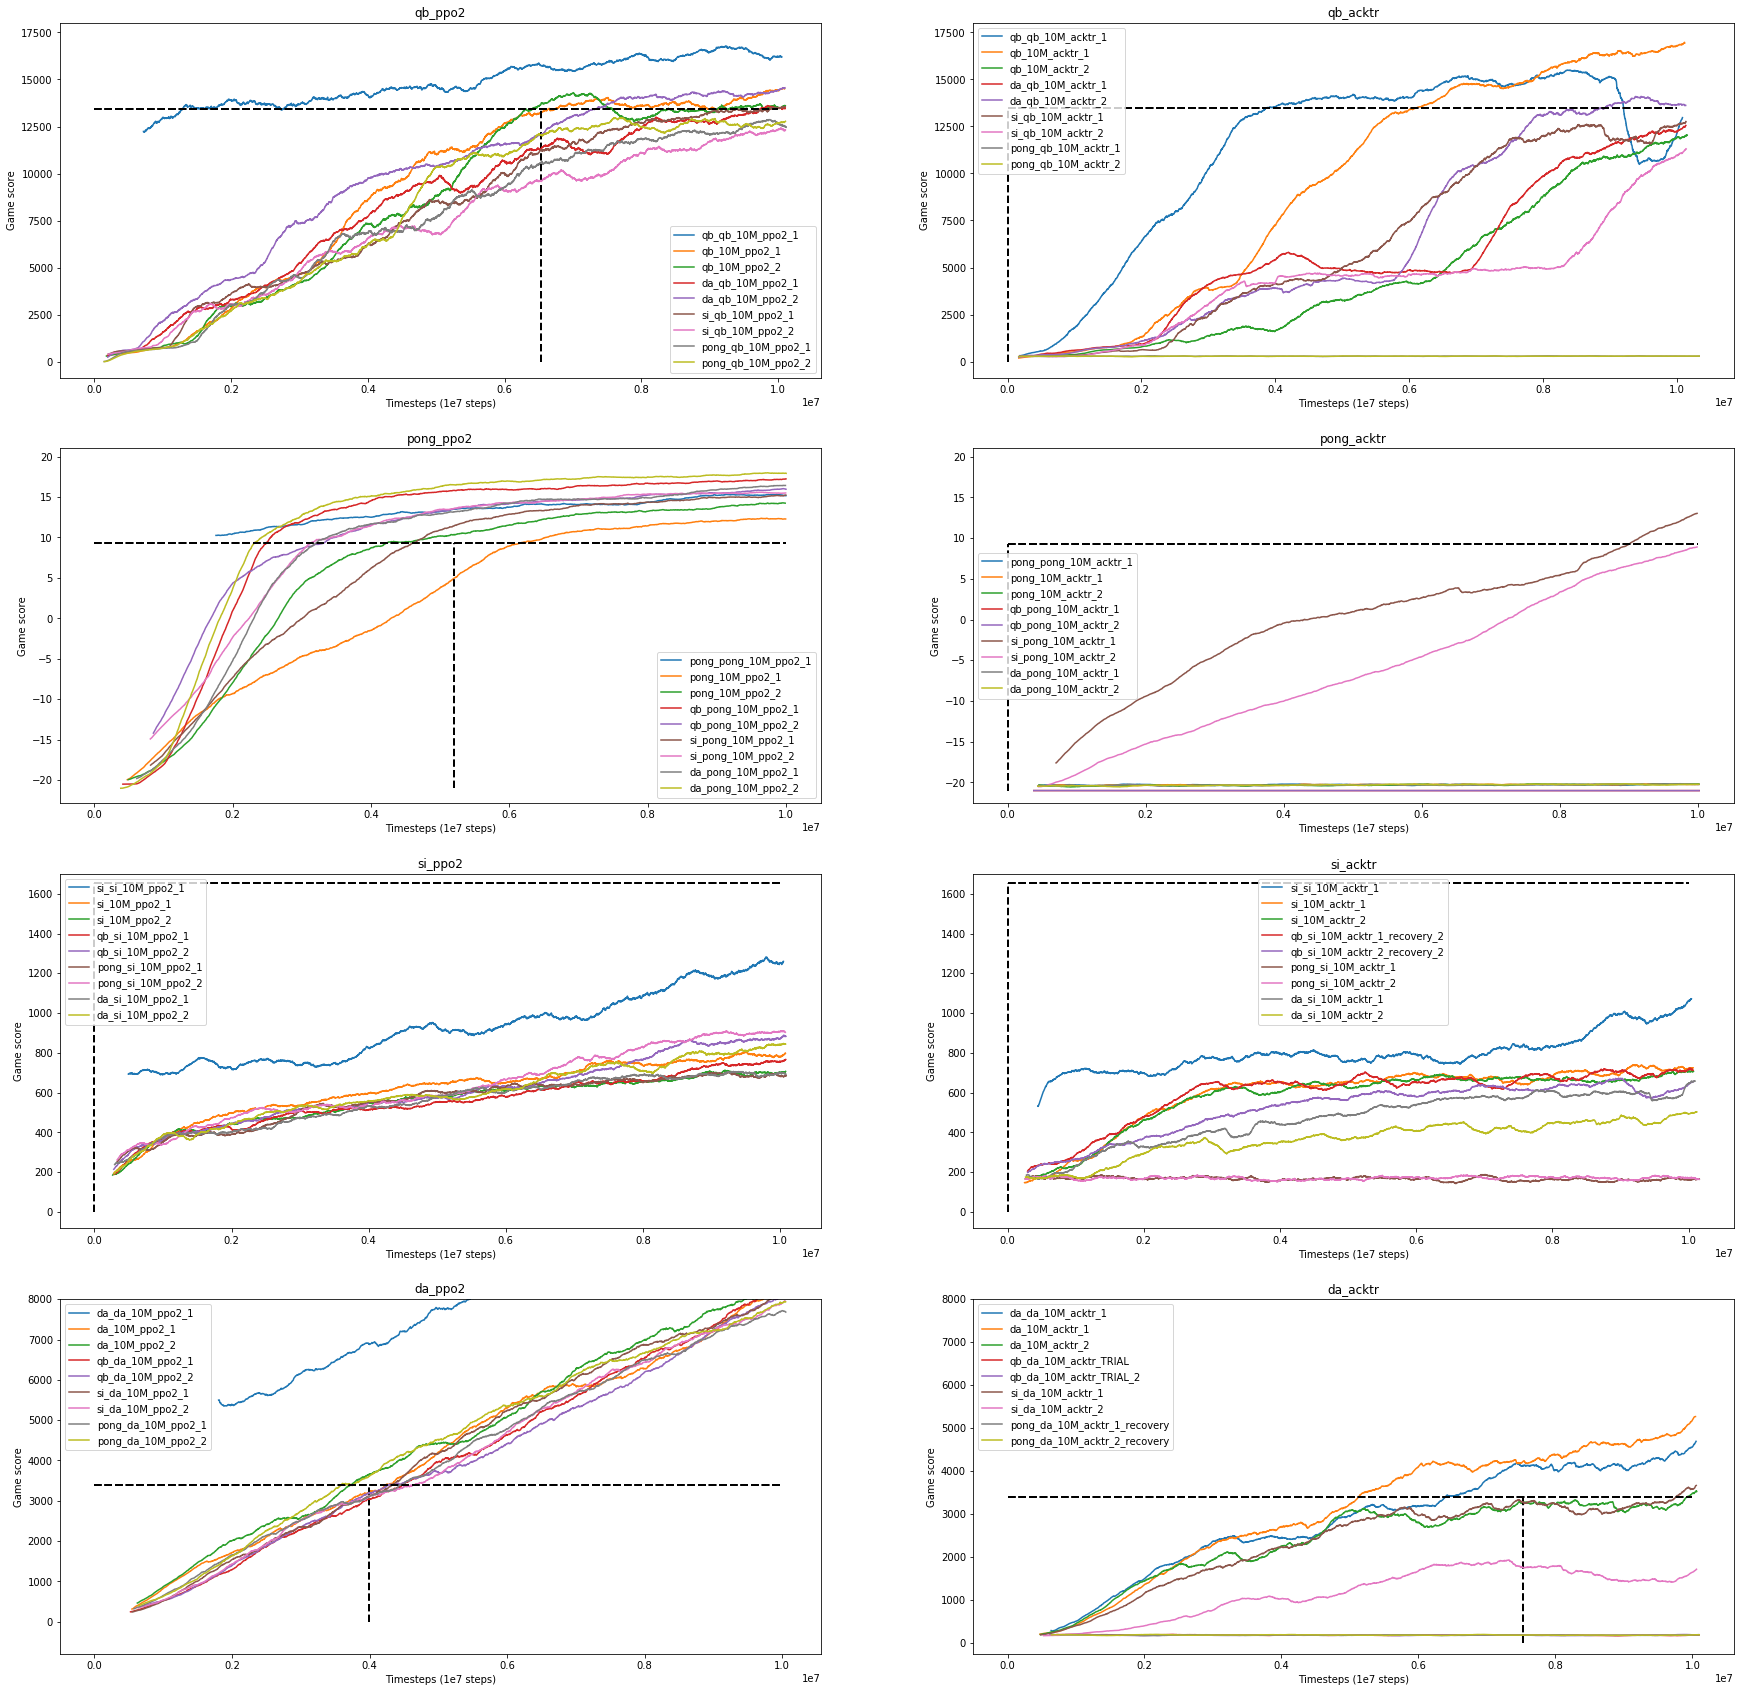

In [157]:
plot_lc(games_algo_dict)

In [32]:
results1 =  pu.load_results('logs/si_pong_10M_acktr_1')
results2 = pu.load_results('logs/si_pong_10M_acktr_2')
r1 = results1[0]
r2 = results2[0]
m1 = r1.monitor
m2 = r2.monitor

In [33]:
n = 500
u1 = m1.rolling(n).mean()
u2 = m2.rolling(n).mean()
s1 = m1.rolling(n).std()
s2 = m2.rolling(n).std()
s_mean = avg(s1.r[1:].mean(0), s2.r[1:].mean(0))
r_mean = avg(m1.r[1:].mean(0), m2.r[1:].mean(0))
                
thres_range = get_thres('pong_acktr')
reward_thres = thres_range[0]
min_thres = thres_range[1]
                
try:
    t_to_thres1 = find_t_at_r(reward_thres, u1, m1)
except:
    t_to_thres1 = 0
try:
    t_to_thres2 = find_t_at_r(reward_thres, u2, m2)
except:
    t_to_thres2 = 0

#t_to_thres = avg(t_to_thres1,t_to_thres2)
r_at_t=0
                
if t_to_thres!=0:
    r_at_t = avg(find_r_at_t(t_to_thres , u1, m1),find_r_at_t(t_to_thres , u2, m2))

In [31]:
(t_to_thres1+1.02e7)/2

9606888.5

In [30]:
find_r_at_t(0.999e7, u2, m2)

8.902

In [28]:
find_r_at_t(0.9e7, u1, m1)

9.24

In [34]:
results1 =  pu.load_results('logs/qb_10M_acktr_1')
results2 = pu.load_results('logs/qb_10M_acktr_2')
r1 = results1[0]
r2 = results2[0]
m1 = r1.monitor
m2 = r2.monitor

In [35]:
n = 500
u1 = m1.rolling(n).mean()
u2 = m2.rolling(n).mean()
s1 = m1.rolling(n).std()
s2 = m2.rolling(n).std()
s_mean = avg(s1.r[1:].mean(0), s2.r[1:].mean(0))
r_mean = avg(m1.r[1:].mean(0), m2.r[1:].mean(0))
                
thres_range = get_thres('qb_acktr')
reward_thres = thres_range[0]
min_thres = thres_range[1]
                
try:
    t_to_thres1 = find_t_at_r(reward_thres, u1, m1)
except:
    t_to_thres1 = 0
try:
    t_to_thres2 = find_t_at_r(reward_thres, u2, m2)
except:
    t_to_thres2 = 0

#t_to_thres = avg(t_to_thres1,t_to_thres2)
r_at_t=0
                
if t_to_thres!=0:
    r_at_t = avg(find_r_at_t(t_to_thres , u1, m1),find_r_at_t(t_to_thres , u2, m2))

In [38]:
t_to_thres1

6082145

In [48]:
find_r_at_t(9.0e6 , u2, m2)

10791.25

In [49]:
find_r_at_t(9.0e6 , u1, m1)

16314.25